# Task 5 : Image Compression using Matrix Factorisation [3 Marks]
    
You have an image patch of size (50x50) that you want to compress using matrix factorization. To do this, you'll split the patch $[N\times N]$ into two smaller matrices of size $[N\times r]$ and $[r\times N]$ using matrix factorization. Compute the compressed patch by multiplying these two matrices and compare the reconstructed image patch with the original patch. Compute the Root Mean Squared Error (RMSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed image patches.

- Test different values for the low-rank $r = [5, 10, 25, 50]$.
- Use Gradient Descent to learn the compressed matrices.
- Display the reconstructed image patches, keeping the original pixel values outside the patch unchanged, and use your compressed matrix for the patch to show how well the reconstruction works.
- Compute the RMSE and PSNR for each value of $r$. 

Here is a reference set of patches that you can choose. You can chose an image of your liking and create patches. You can choose the image shown below as well. **[3 Marks]**

<div style="display: flex;">
  <img src="sample_images/1colour.jpg" alt="Image 1" width="250"/>
  <img src="sample_images/2-3_colours.jpg" alt="Image 2" width="270"/>
  <img src="sample_images/multiple_colours.jpg" alt="Image 3" width="265"/>
</div>

<br>

- Present your results in a Jupyter Notebook or an MD file. If you choose to use an MD file, also include your code as a separate `.py` or `.ipynb` file.
- The assignment is worth 20 marks but will be scaled down to 10 marks.
- Carefully read the questions and make sure you answer all parts, as missing some could result in losing marks.
- Ensure your code is readable and submitted before the deadline.
- For any questions, use the #assignments channel on Slack.
- Be efficient by reusing code from previous tasks wherever possible to solve new problems. In a few question, some task can be used as a base to solve the next task.



## Basic Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from metrics import calculate_rmse, calculate_psnr

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Util functions

In [5]:
def factorize(A, k, device=torch.device("cpu"), epochs=1000):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer use gradient decent (normal, not stochastic)
    optimizer = optim.SGD([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(epochs):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

def display_image(image):
	plt.imshow(image.clone().detach(), cmap='gray')
	plt.axis('off')

## Preparing the image

In this section we work with both grey scale images and coloured images, we extract 3 patches from the given image and trying to compress them using matrix factorization.

### Grey Scale Image

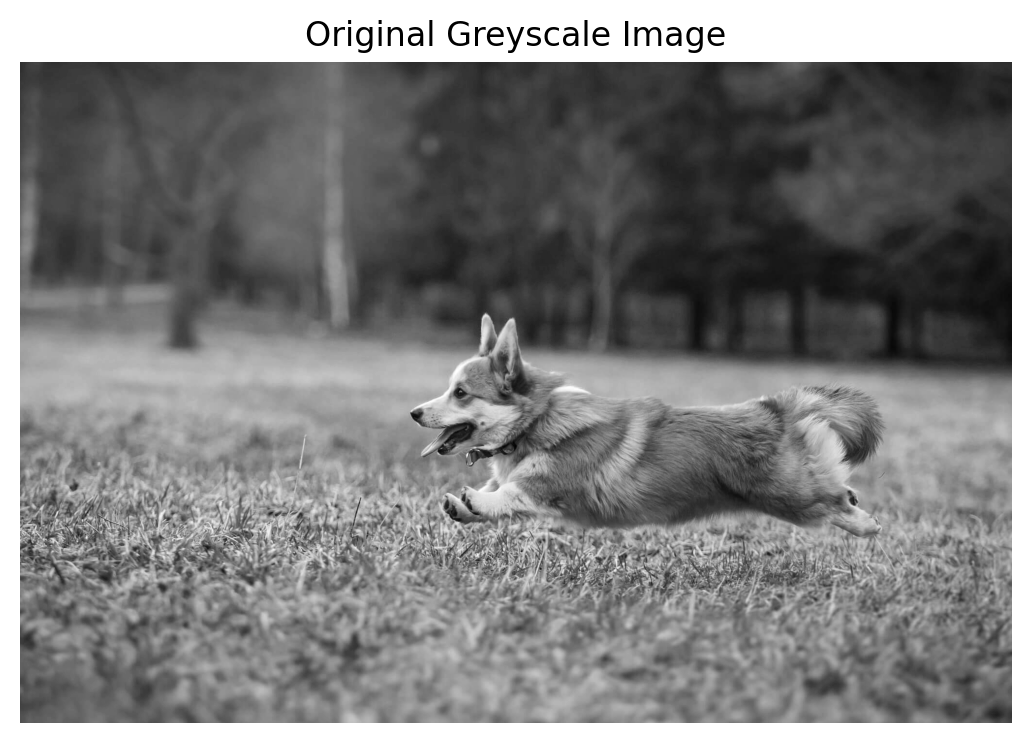

In [11]:
# Read in a image from torchvision
img = torchvision.io.read_image("./sample_images/SAM dog.jpg")
img = img.clone().detach().float()
img = img.mean(dim=0, keepdim=False)
plt.title("Original Greyscale Image")
display_image(img)

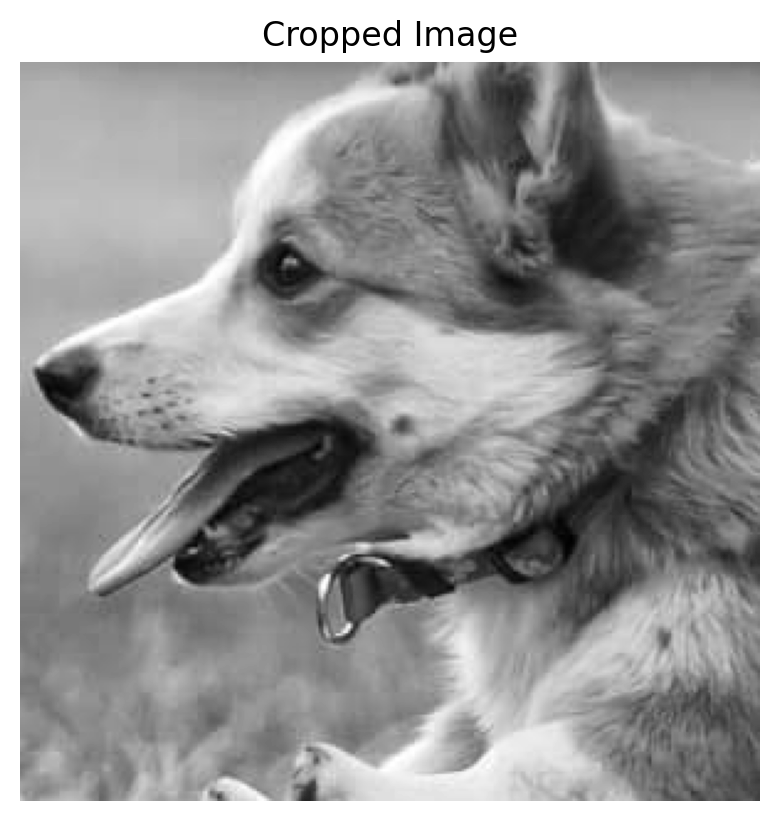

In [10]:
crop = torchvision.transforms.functional.crop(img, 600, 800, 300, 300)
plt.title("Cropped Image")
display_image(crop)

In [13]:
def get_patch(img, case):
    match case:
        case 1:
            return torchvision.transforms.functional.crop(img, 0, 0, 50, 50)
        case 2:
            return torchvision.transforms.functional.crop(img, 50, 50, 50, 50)
        case 3:
            return torchvision.transforms.functional.crop(img, 175, 75, 50, 50)

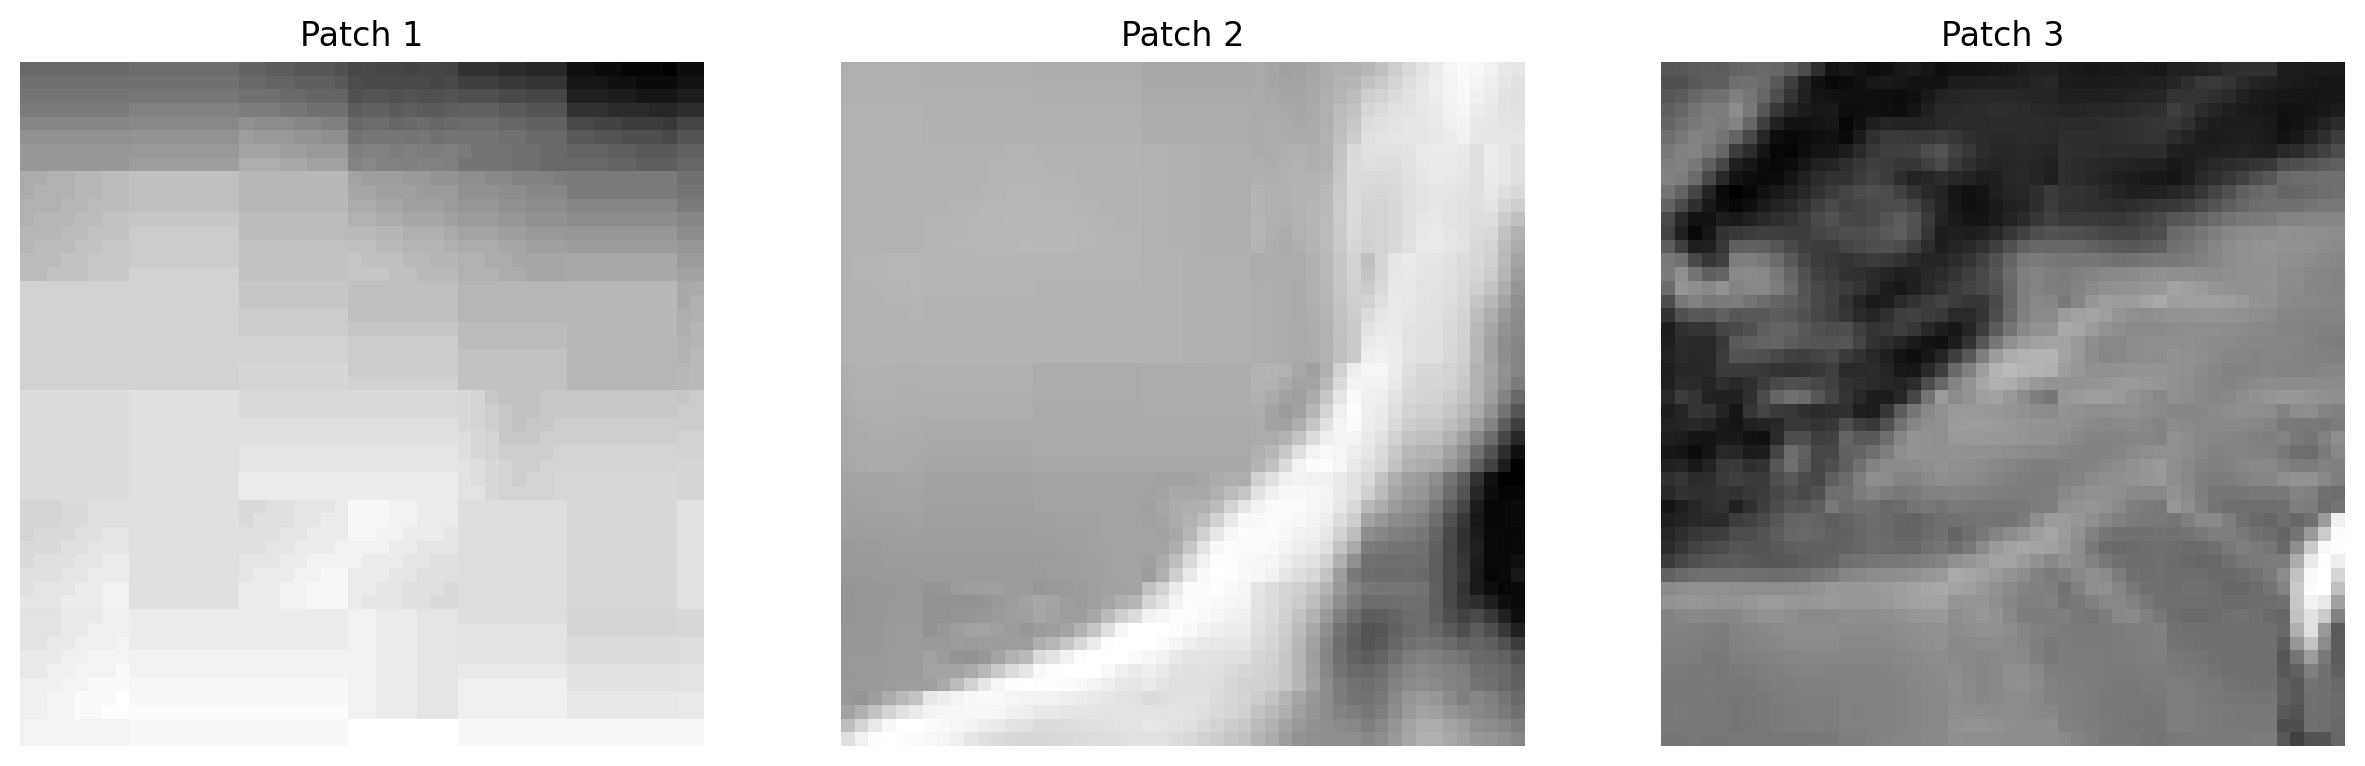

In [16]:
plt.figure(figsize=(15, 5))

patch1 = get_patch(crop, 1)
plt.subplot(1, 3, 1)
plt.title("Patch 1")
display_image(patch1)

patch2 = get_patch(crop, 2)
plt.subplot(1, 3, 2)
plt.title("Patch 2")
display_image(patch2)

patch3 = get_patch(crop, 3)
plt.subplot(1, 3, 3)
plt.title("Patch 3")
display_image(patch3)

In [26]:
def plot_original_reconstructed(original, reconstructed):
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].imshow(original, cmap='gray')
	ax[0].set_title("Original")
	ax[1].imshow(reconstructed, cmap='gray')
	ax[1].set_title("Reconstructed")
	plt.show()
 
def calculate_metrics(original, reconstructed):
	rmse = calculate_rmse(original, reconstructed)
	psnr = calculate_psnr(original, reconstructed)
	return rmse, psnr
 
def factorize_and_reconstruct_patch(patch, r, plot=False):
	patch = get_patch(crop, patch)
	W, H, _ = factorize(patch, r, device=device, epochs=1000)
	reconstructed = torch.mm(W, H).detach().cpu()
	if plot:
		plt.suptitle(f"Metrics vs r for patch {patch} with r={r}")
		plot_original_reconstructed(patch, reconstructed)
	return calculate_metrics(patch.detach().numpy(), reconstructed.detach().numpy())
 
def plot_metrics_vs_r(patch, r_values):
	rmse_values = []
	psnr_values = []
	for r in r_values:
		rmse, psnr = factorize_and_reconstruct_patch(patch, r, plot=False)
		rmse_values.append(rmse)
		psnr_values.append(psnr)
		print(f"patch={patch} r={r}, RMSE={rmse}, PSNR={psnr}")
 
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].plot(r_values, rmse_values)
	ax[0].set_title("RMSE vs r for patch {}".format(patch))
	ax[0].set_xlabel("r")
	ax[0].set_ylabel("RMSE")
	ax[1].plot(r_values, psnr_values)
	ax[1].set_title("PSNR vs r for patch {}".format(patch))
	ax[1].set_xlabel("r")
	ax[1].set_ylabel("PSNR")
	plt.show()


Patch 1


<Figure size 640x480 with 0 Axes>

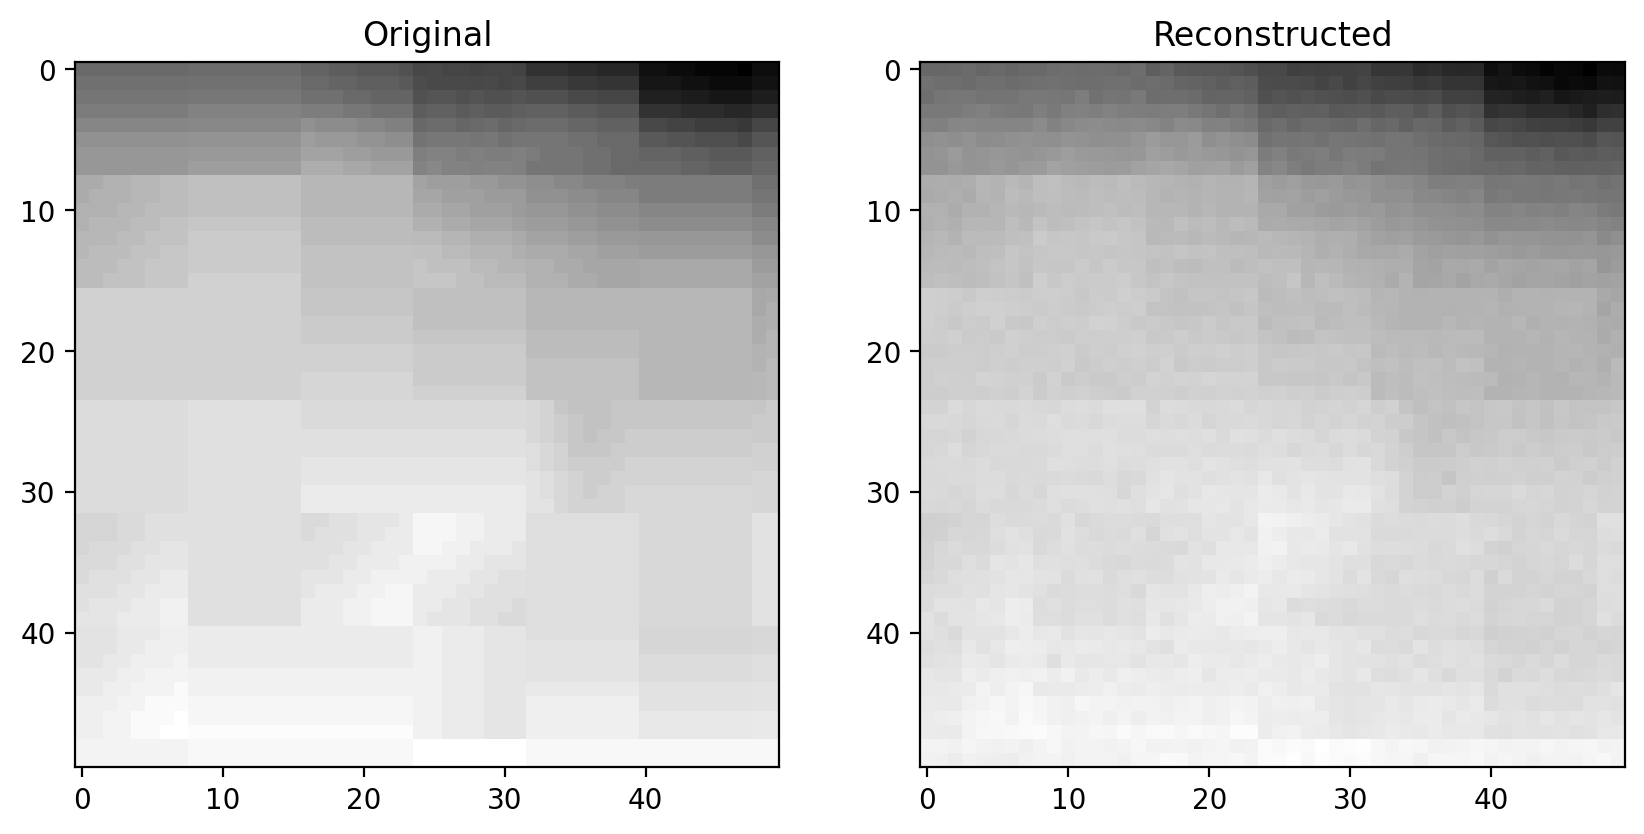

<Figure size 640x480 with 0 Axes>

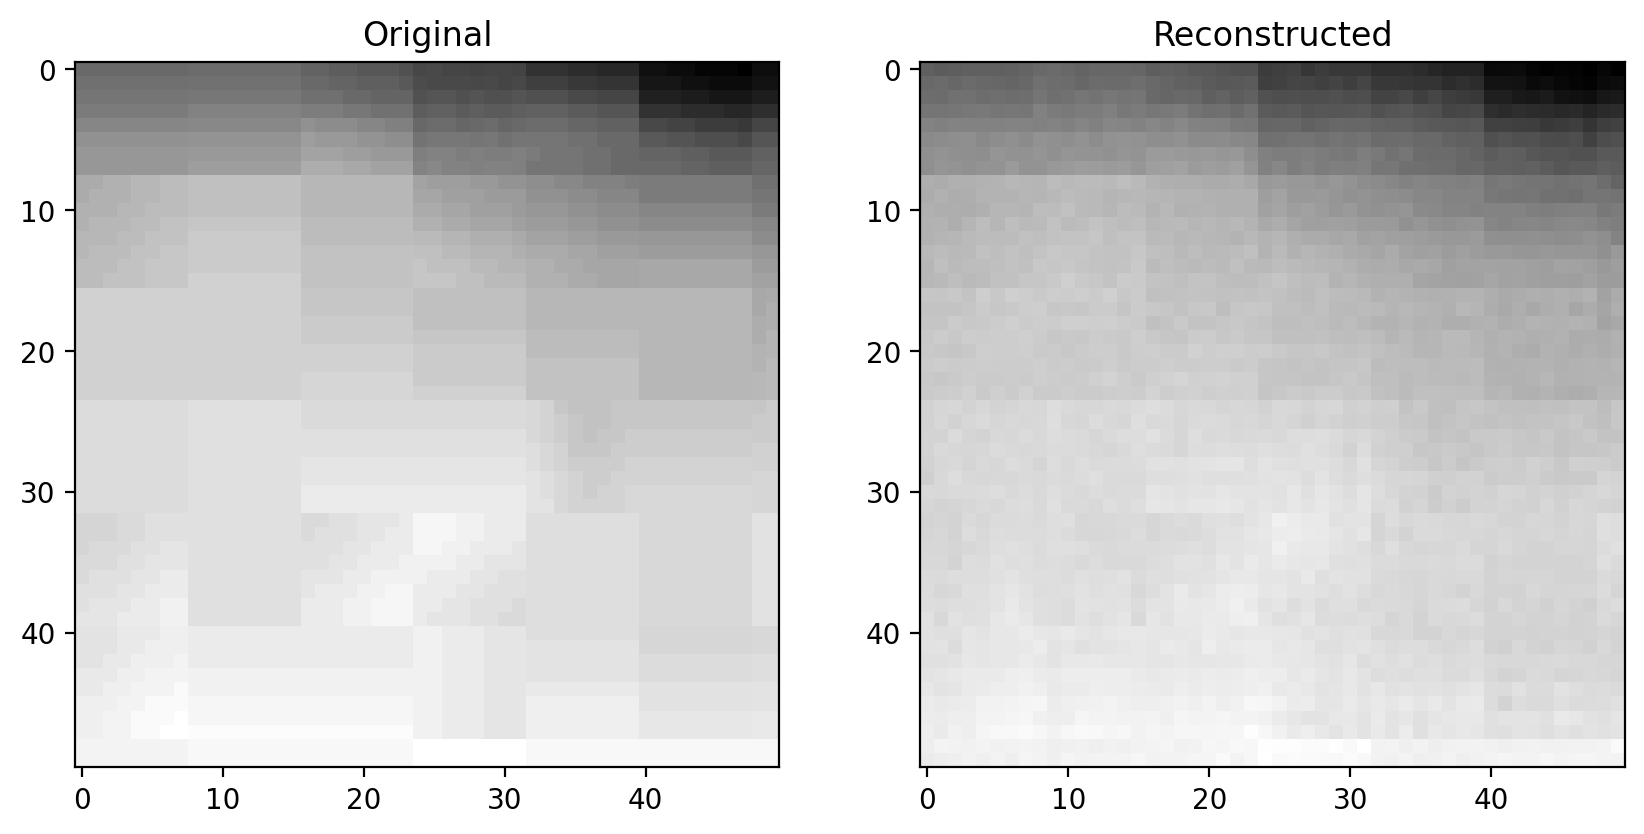

<Figure size 640x480 with 0 Axes>

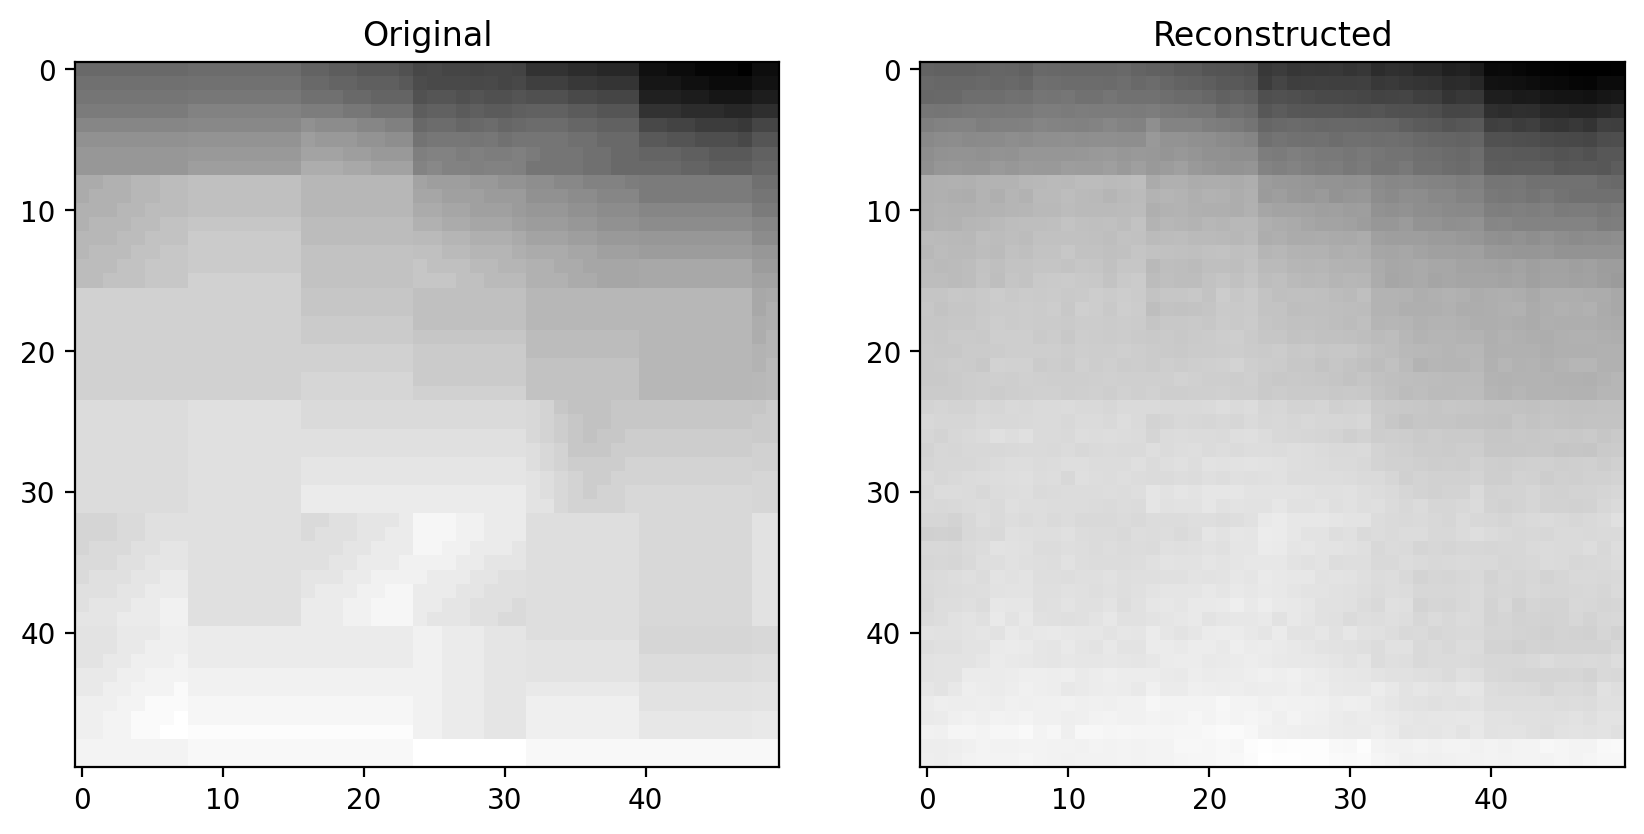

Patch 2


<Figure size 640x480 with 0 Axes>

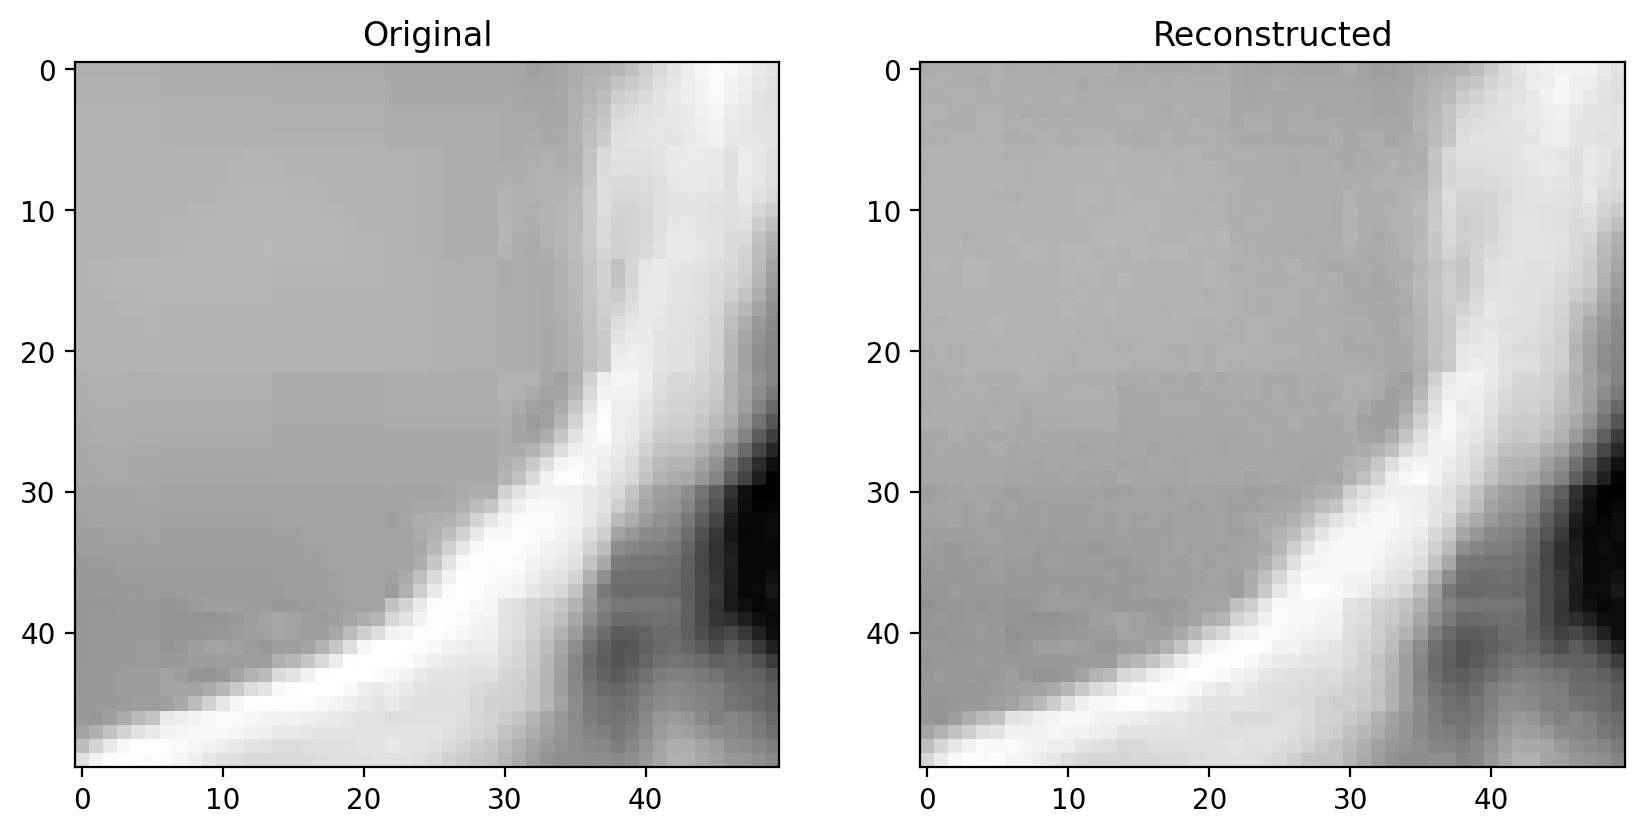

Patch 3


<Figure size 640x480 with 0 Axes>

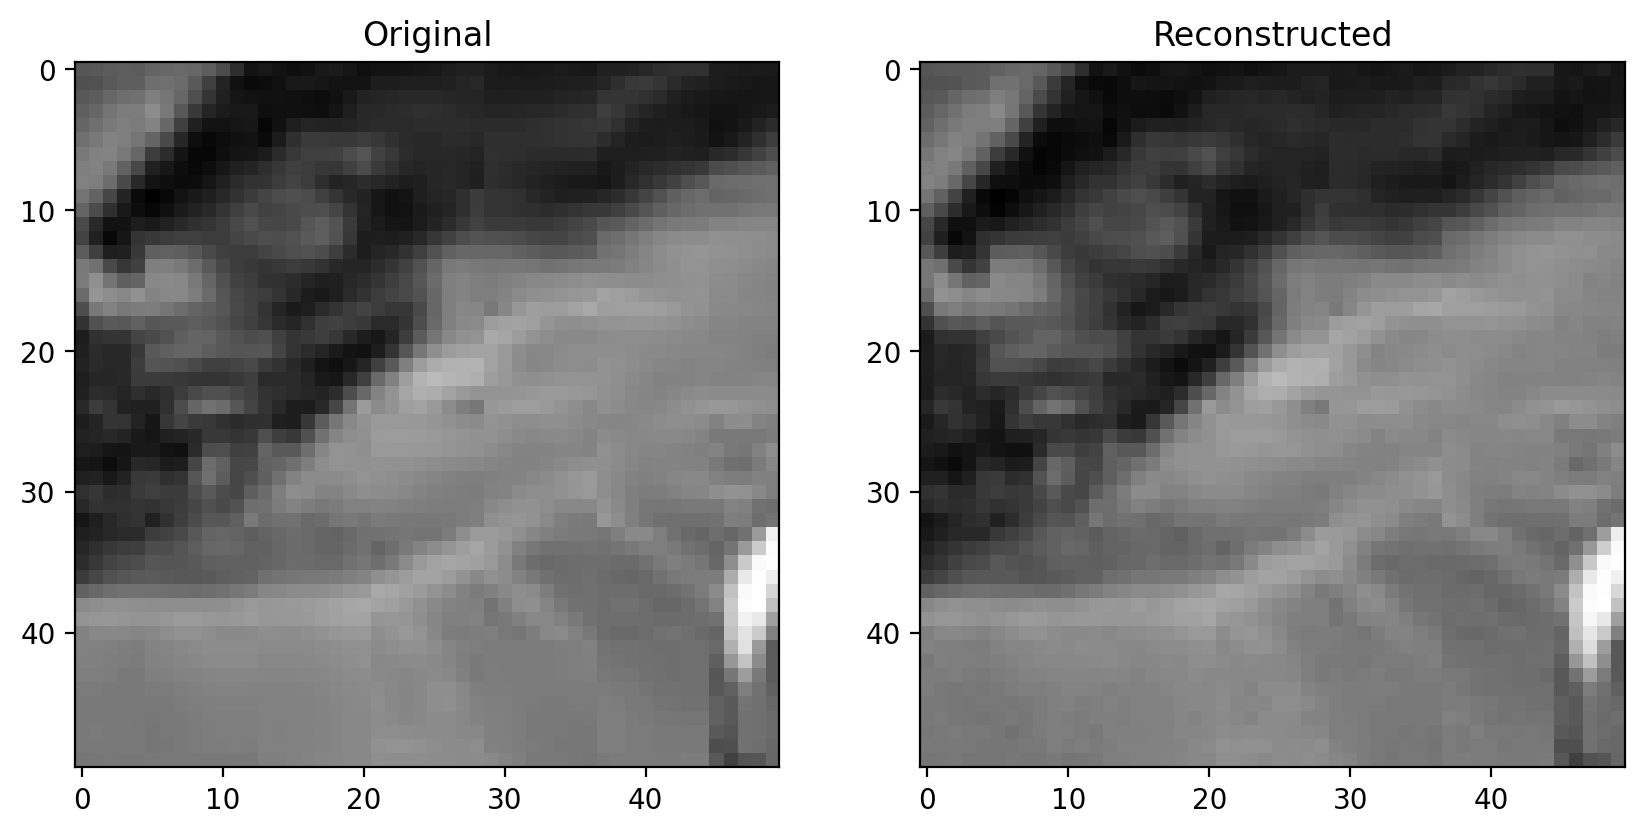

(1.4473796, 44.90779399871826)

In [27]:
print("Patch 1")
factorize_and_reconstruct_patch(1, 50, plot=True)
factorize_and_reconstruct_patch(1, 25, plot=True)
factorize_and_reconstruct_patch(1, 10, plot=True)
print("Patch 2")
factorize_and_reconstruct_patch(2, 50, plot=True)
print("Patch 3")
factorize_and_reconstruct_patch(3, 50, plot=True)

patch=1 r=5, RMSE=1.6362359523773193, PSNR=41.35889530181885
patch=1 r=10, RMSE=2.6306235790252686, PSNR=37.23463773727417
patch=1 r=25, RMSE=0.532549262046814, PSNR=51.10861778259277
patch=1 r=50, RMSE=0.532560408115387, PSNR=51.108436584472656


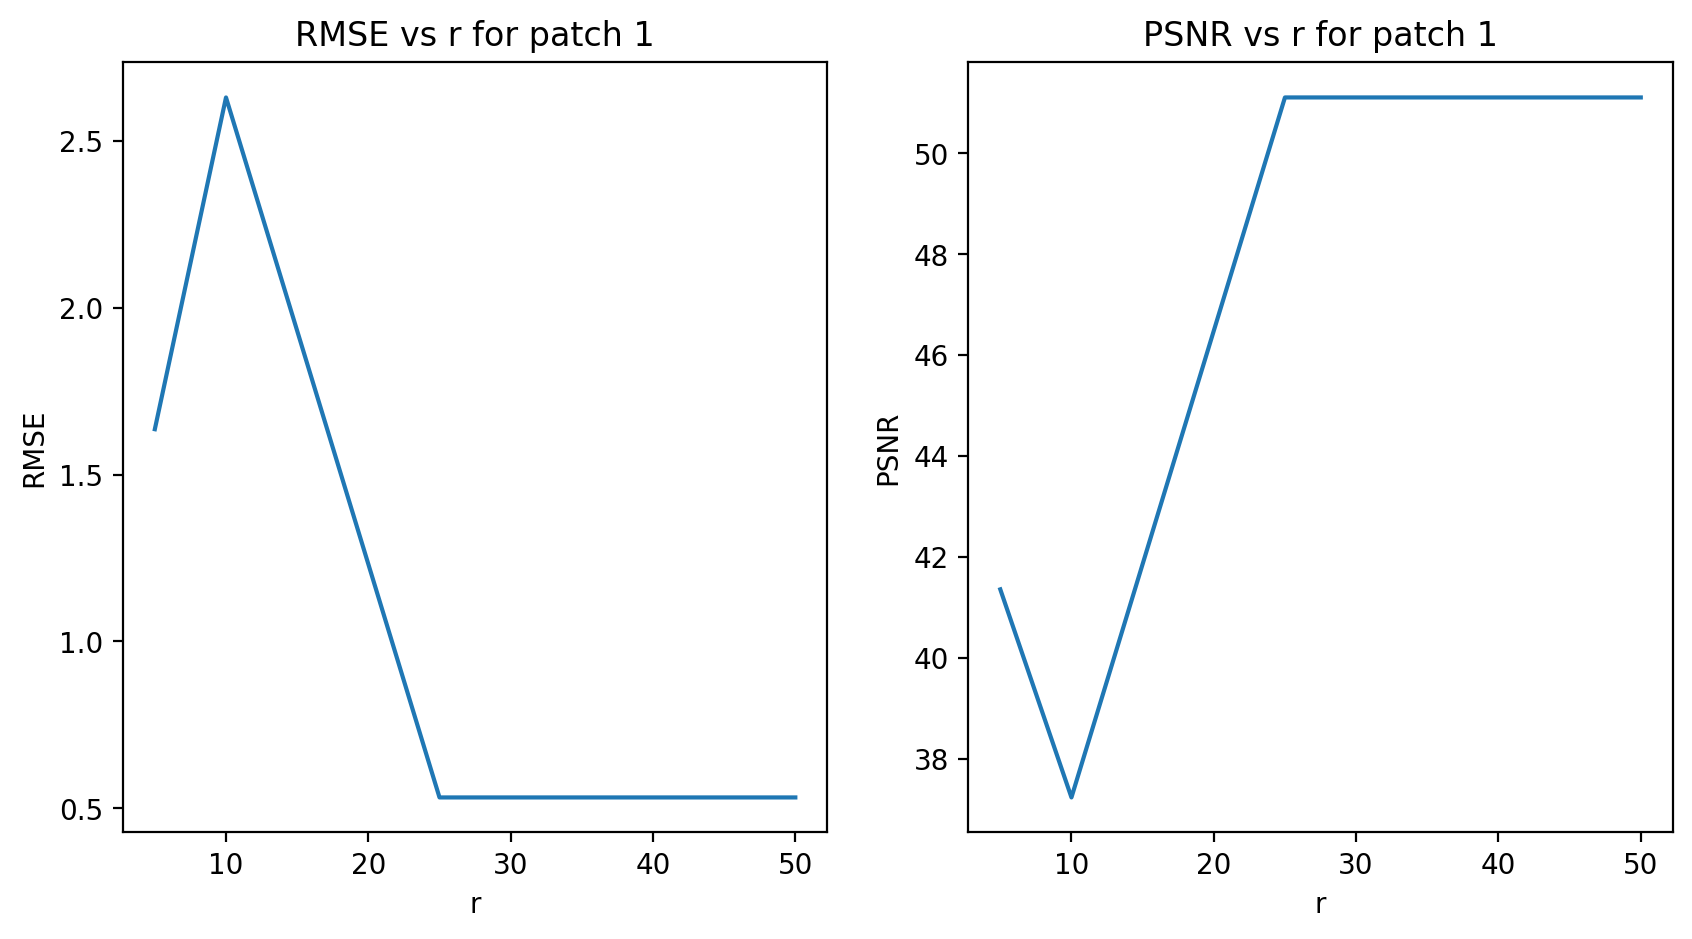

patch=2 r=5, RMSE=6.103981971740723, PSNR=32.41853952407837
patch=2 r=10, RMSE=2.2859034538269043, PSNR=40.949645042419434
patch=2 r=25, RMSE=0.9240461587905884, PSNR=48.81692886352539
patch=2 r=50, RMSE=3.3323452472686768, PSNR=37.67580270767212


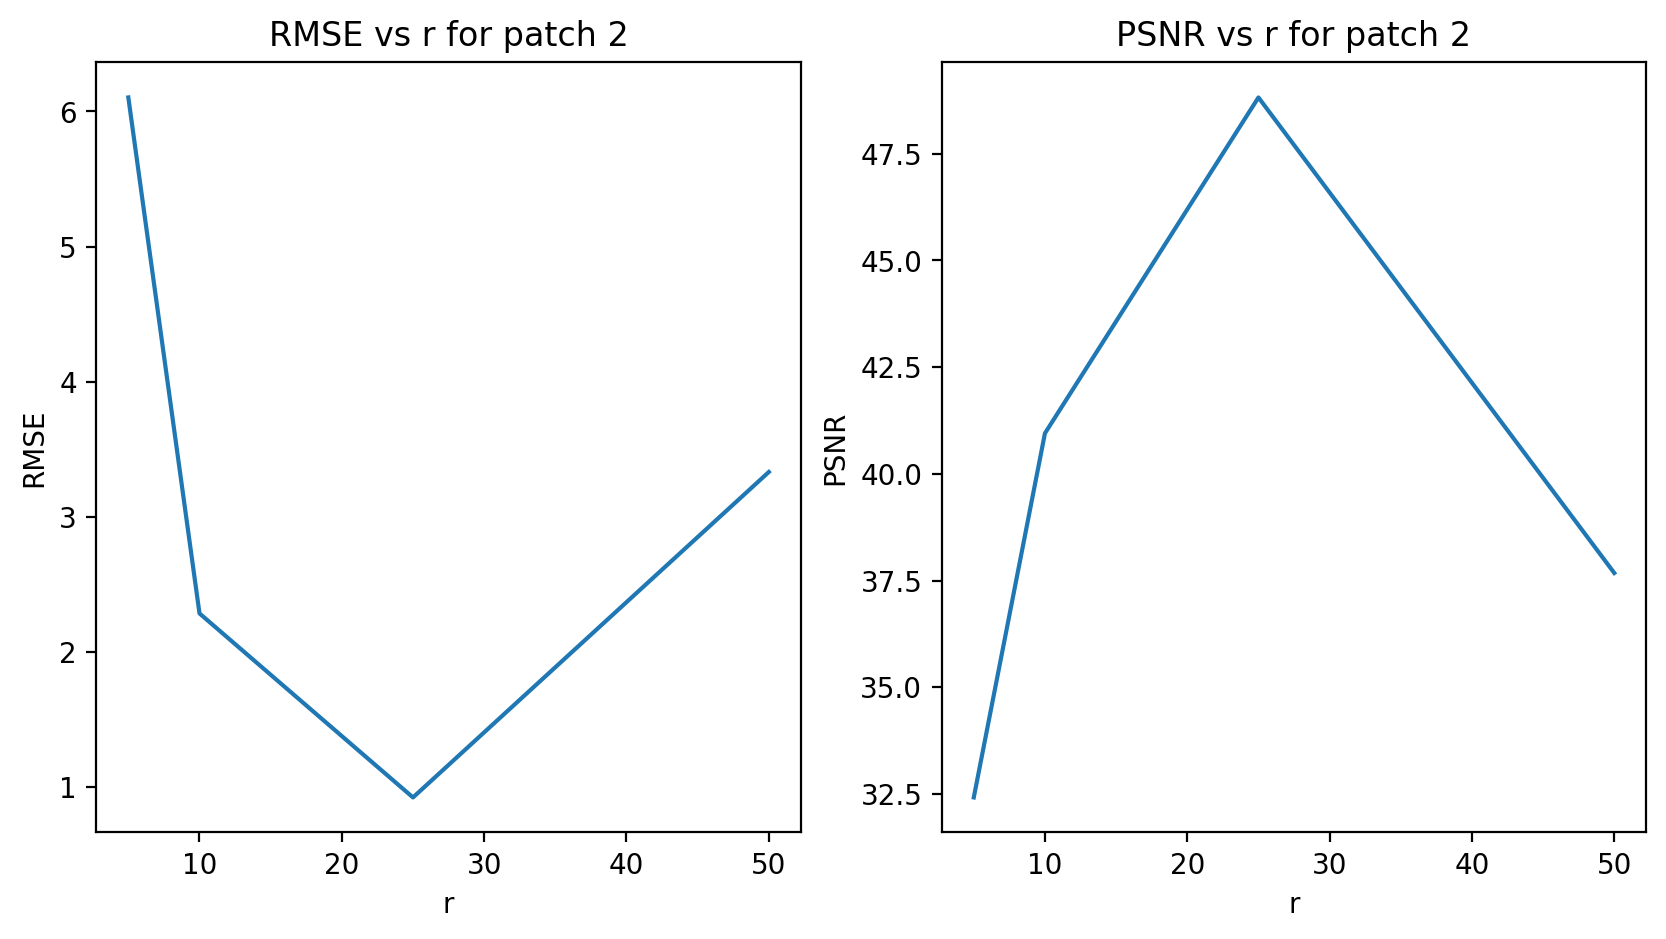

patch=3 r=5, RMSE=11.379051208496094, PSNR=26.997320652008057
patch=3 r=10, RMSE=4.358702659606934, PSNR=35.332298278808594
patch=3 r=25, RMSE=1.1663843393325806, PSNR=46.78260803222656
patch=3 r=50, RMSE=0.3285171687602997, PSNR=57.78828144073486


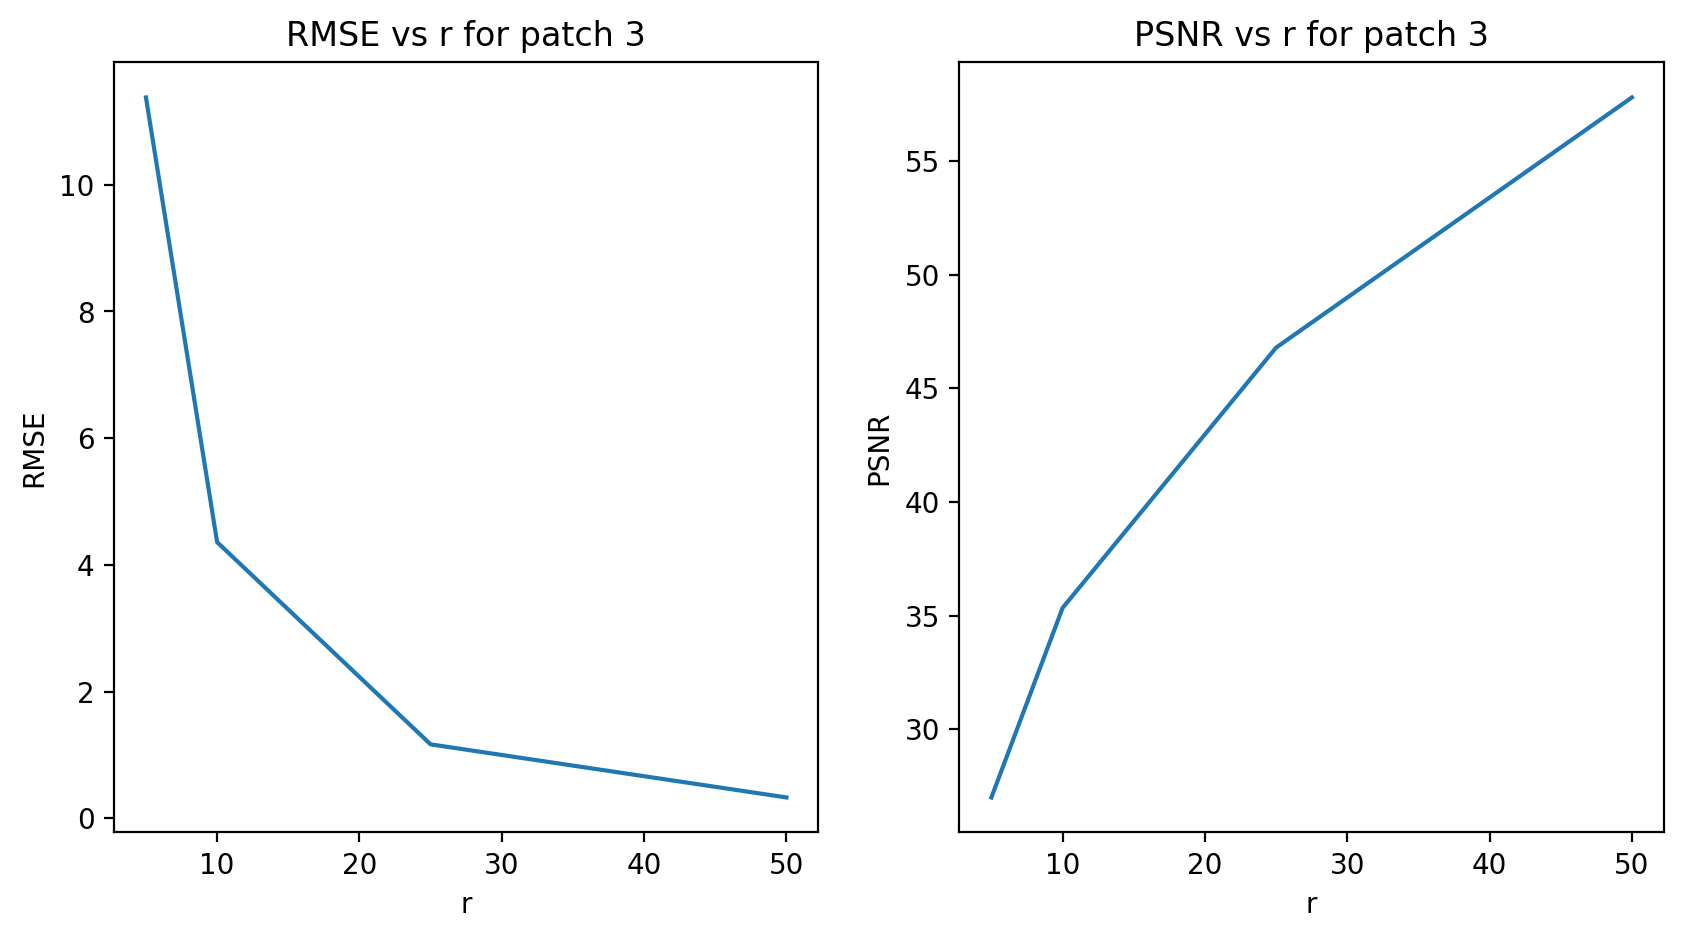

In [24]:
plot_metrics_vs_r(1, [5, 10, 25, 50])
plot_metrics_vs_r(2, [5, 10, 25, 50])
plot_metrics_vs_r(3, [5, 10, 25, 50])

Shape of the original Image: torch.Size([3, 1365, 2048])
Shape of the Cropped image torch.Size([3, 300, 300])
Shape of Greyscale image: torch.Size([300, 300])


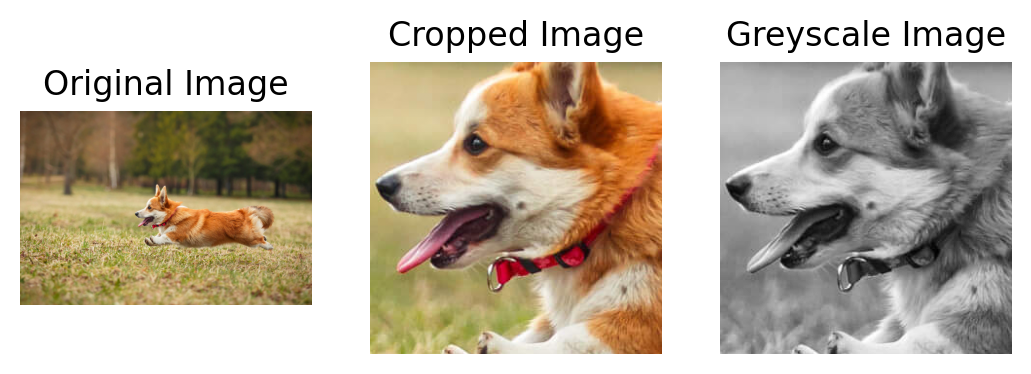

In [29]:
def display_image(img, gray=True):
    if gray:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.axis('off')

# Read in a image from torchvision
def load_image(path, crop_args=(600, 800, 300, 300)):
	img = torchvision.io.read_image(path)
	print("Shape of the original Image:", img.shape)

	img = (img.clone().detach().to(float))
	plt.subplot(1, 3, 1)
	display_image(img.permute(1, 2, 0) / 255, gray=False)
	plt.title("Original Image")

	img = torchvision.transforms.functional.crop(img.clone().detach().to(float), *crop_args)
	greyscale = img.mean(dim=0, keepdim=False) # convert to grayscale
	print("Shape of the Cropped image", img.shape)
	plt.subplot(1, 3, 2)
	display_image(img.permute(1, 2, 0) / 255)
	plt.title("Cropped Image")
 
	# crop = torchvision.transforms.functional.crop(img, 400, 200, 800, 500)
	print("Shape of Greyscale image:", greyscale.shape)
	plt.subplot(1, 3, 3)
	display_image(greyscale)
	plt.title("Greyscale Image")
	return img, greyscale

img, _ = load_image("./sample_images/SAM dog.jpg")

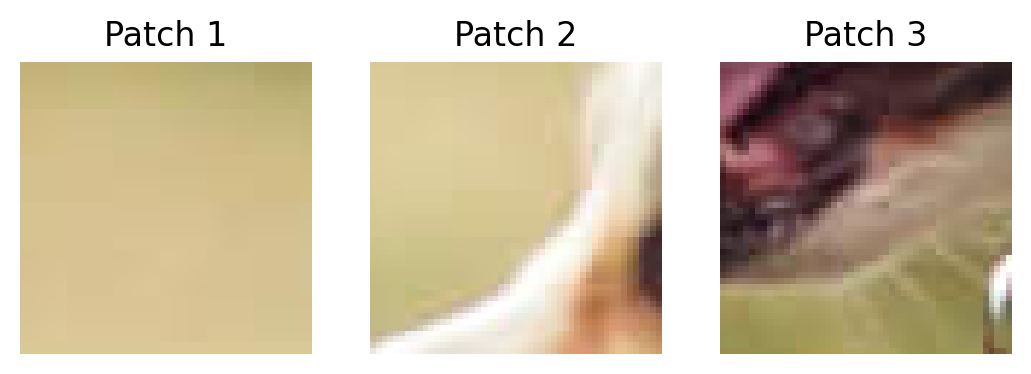

In [30]:
patch1 = get_patch(img, 1)
patch2 = get_patch(img, 2)
patch3 = get_patch(img, 3)

plt.subplot(1, 3, 1)
plt.title("Patch 1")
display_image(get_patch(img, 1).permute(1, 2, 0) / 255, gray=False)
plt.subplot(1, 3, 2)
plt.title("Patch 2")
display_image(get_patch(img, 2).permute(1, 2, 0) / 255, gray=False)
plt.subplot(1, 3, 3)
plt.title("Patch 3")
display_image(get_patch(img, 3).permute(1, 2, 0) / 255, gray=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10895671..1.0831381].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0350529].


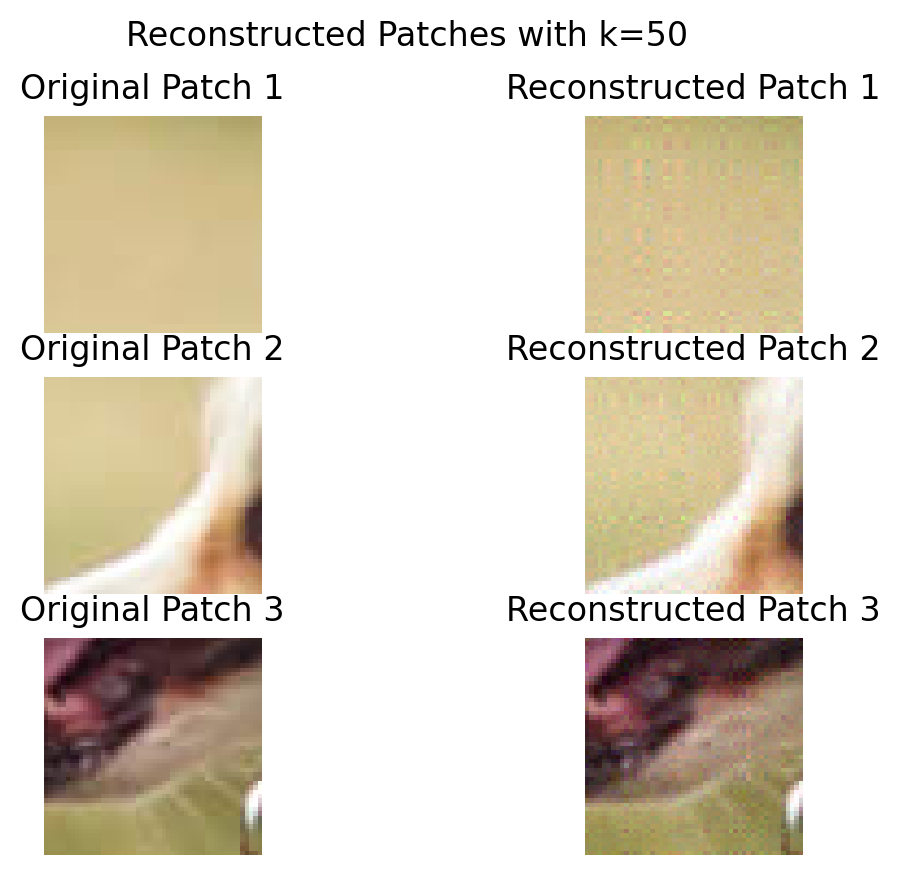

In [35]:
def factorize_coloured_img(masked_img, k):
    # masked_img, mask = mask_image(img, prop, colour=True)
    W_R, H_R, loss_R = factorize(masked_img[0, :, :], k, device=device, epochs=5000)
    W_G, H_G, loss_G = factorize(masked_img[1, :, :], k, device=device, epochs=5000)
    W_B, H_B, loss_B = factorize(masked_img[2, :, :], k, device=device, epochs=5000)
    reconstructed_img = torch.stack([torch.mm(W_R, H_R), torch.mm(W_G, H_G), torch.mm(W_B, H_B)])
    reconstructed_img = torch.clamp(reconstructed_img, 0, 255).detach().cpu()
    return reconstructed_img, masked_img, loss_R, loss_G, loss_B

k = 50
plt.suptitle(f"Reconstructed Patches with k={k}")

reconstructed, _, _, _, _ = factorize_coloured_img(patch1 / 255, k)
plt.subplot(3, 2, 1)
plt.title("Original Patch 1")
display_image(patch1.permute(1, 2, 0) / 255, gray=False)
plt.subplot(3, 2, 2)
plt.title("Reconstructed Patch 1")
display_image(reconstructed.permute(1, 2, 0), gray=False)

reconstructed, _, _, _, _ = factorize_coloured_img(patch2 / 255, k)
plt.subplot(3, 2, 3)
plt.title("Original Patch 2")
display_image(patch2.permute(1, 2, 0) / 255, gray=False)
plt.subplot(3, 2, 4)
plt.title("Reconstructed Patch 2")
display_image(reconstructed.permute(1, 2, 0), gray=False)

reconstructed, _, _, _, _ = factorize_coloured_img(patch3 / 255, k)
plt.subplot(3, 2, 5)
plt.title("Original Patch 3")
display_image(patch3.permute(1, 2, 0) / 255, gray=False)
plt.subplot(3, 2, 6)
plt.title("Reconstructed Patch 3")
display_image(reconstructed.permute(1, 2, 0), gray=False)

patch=1 r=5, RMSE=1.9676913397691835, PSNR=41.00870598964385
patch=1 r=10, RMSE=1.5307468767505337, PSNR=43.189777833727334
patch=1 r=25, RMSE=2.032262500221972, PSNR=40.7282494030892
patch=1 r=50, RMSE=2.4328097404829645, PSNR=39.16568255434855


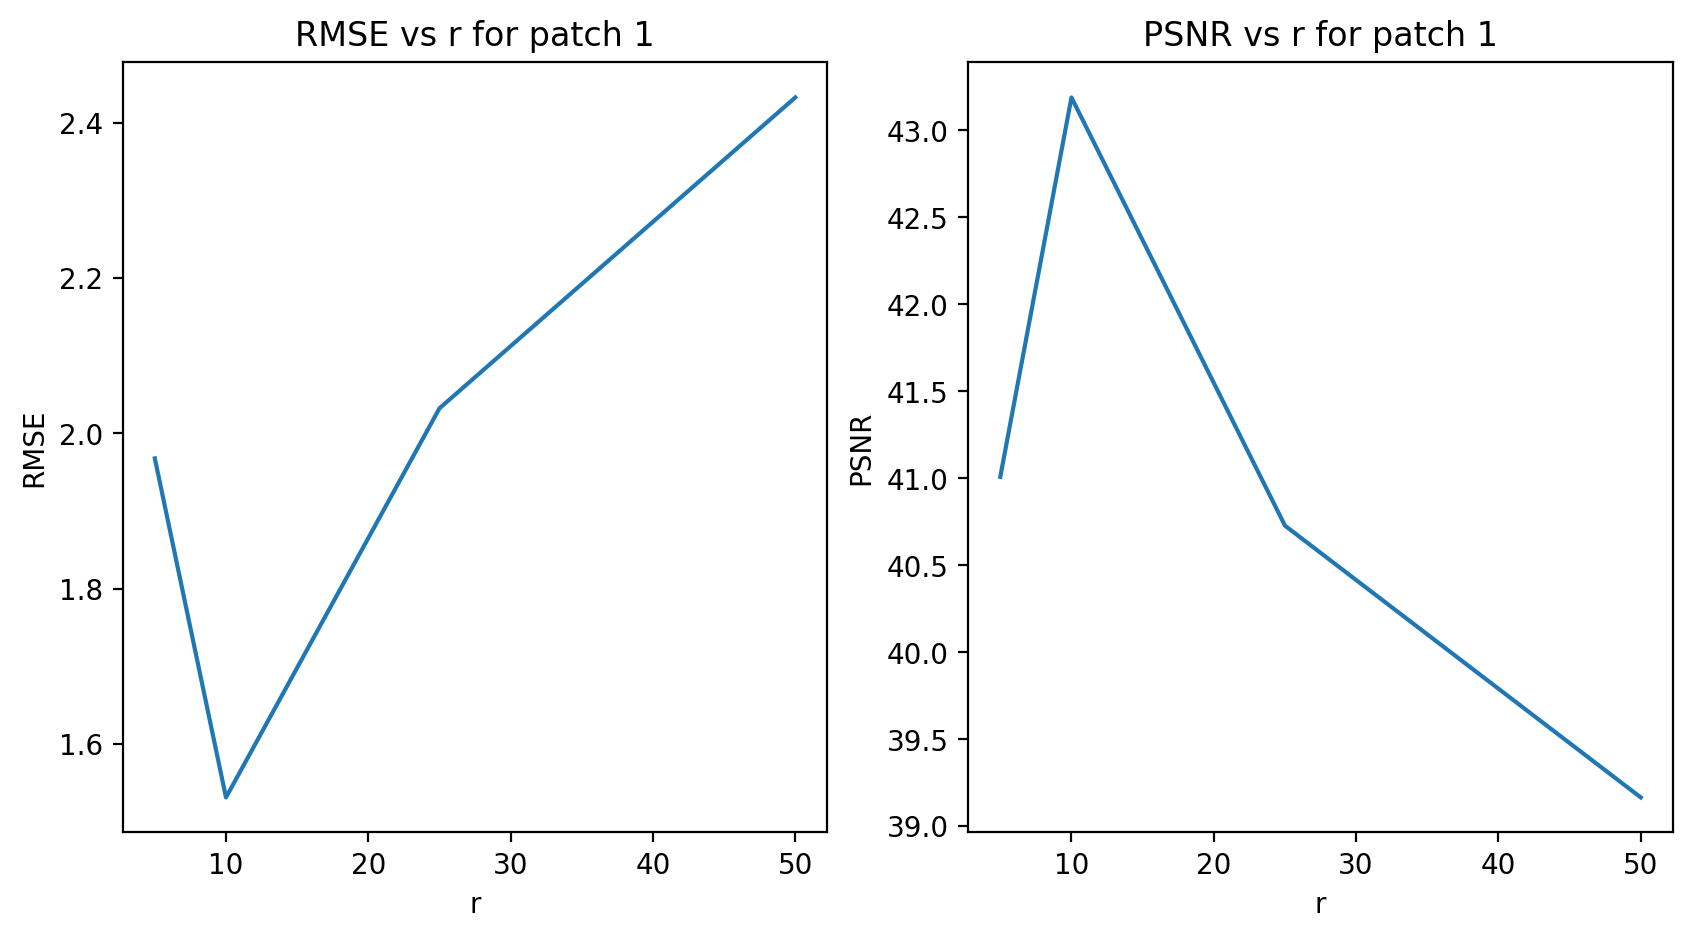

patch=2 r=5, RMSE=6.482754725168734, PSNR=31.895611800779168
patch=2 r=10, RMSE=2.3628722167660436, PSNR=40.661998892950464
patch=2 r=25, RMSE=2.0556982223547693, PSNR=41.871616402073116
patch=2 r=50, RMSE=2.314710307837263, PSNR=40.84087069581335


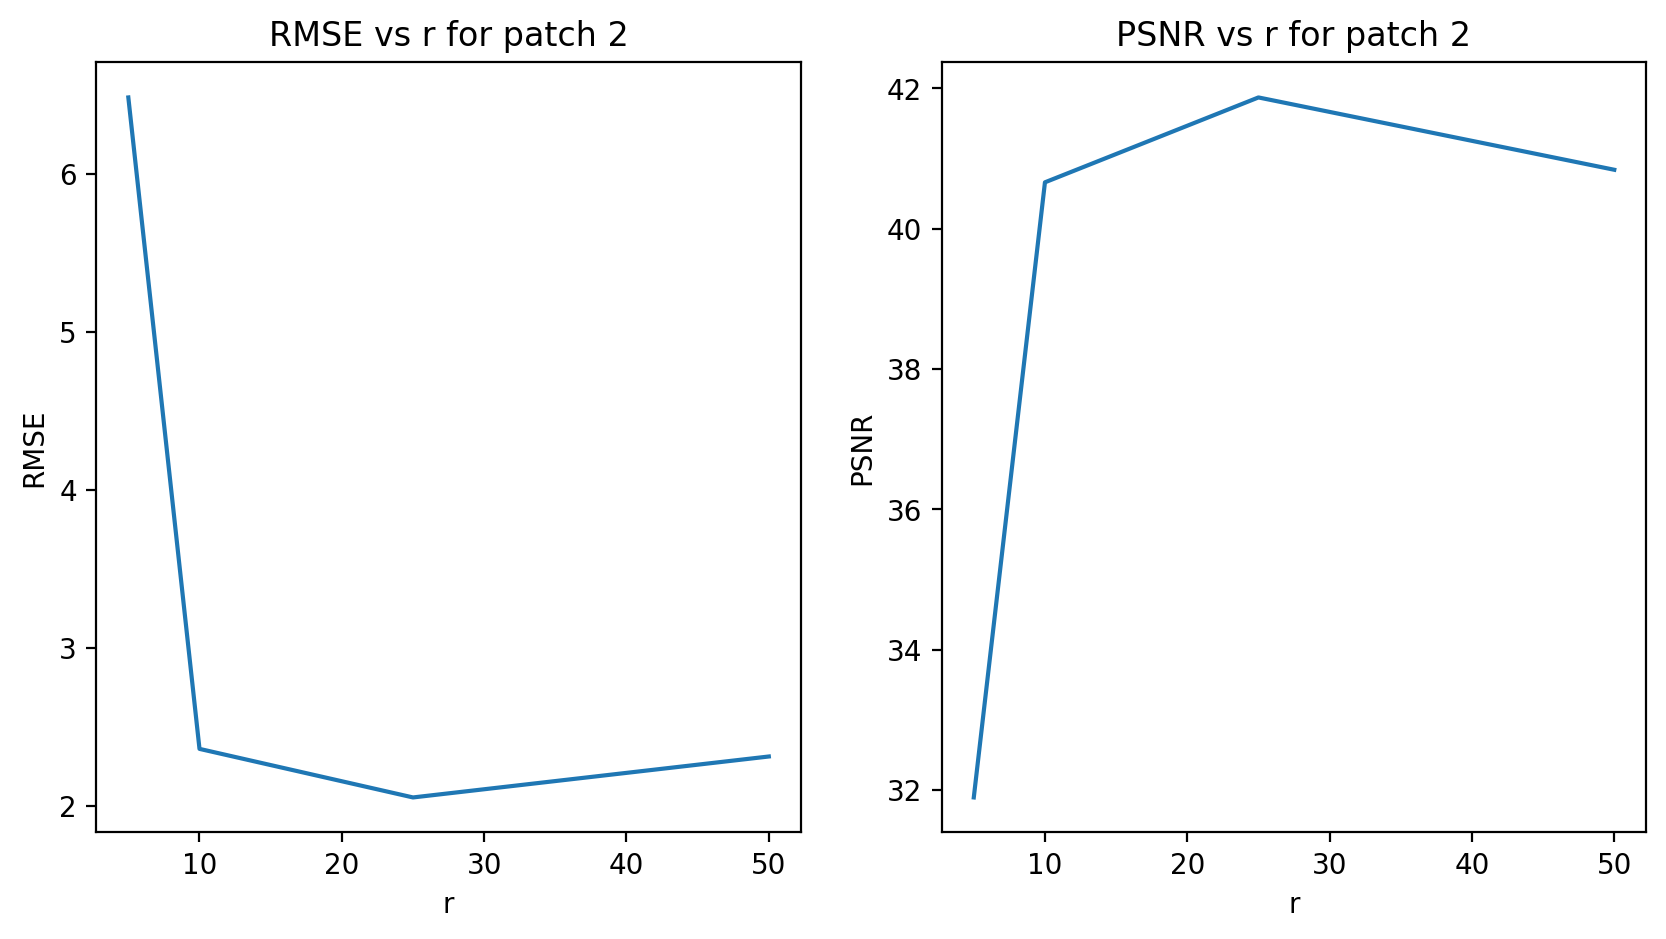

patch=3 r=5, RMSE=11.293202572868989, PSNR=27.074461240519184
patch=3 r=10, RMSE=4.423529973009859, PSNR=35.2154241223702
patch=3 r=25, RMSE=1.1838804087295427, PSNR=46.66464693344175
patch=3 r=50, RMSE=1.2359861587776686, PSNR=46.29053146223384


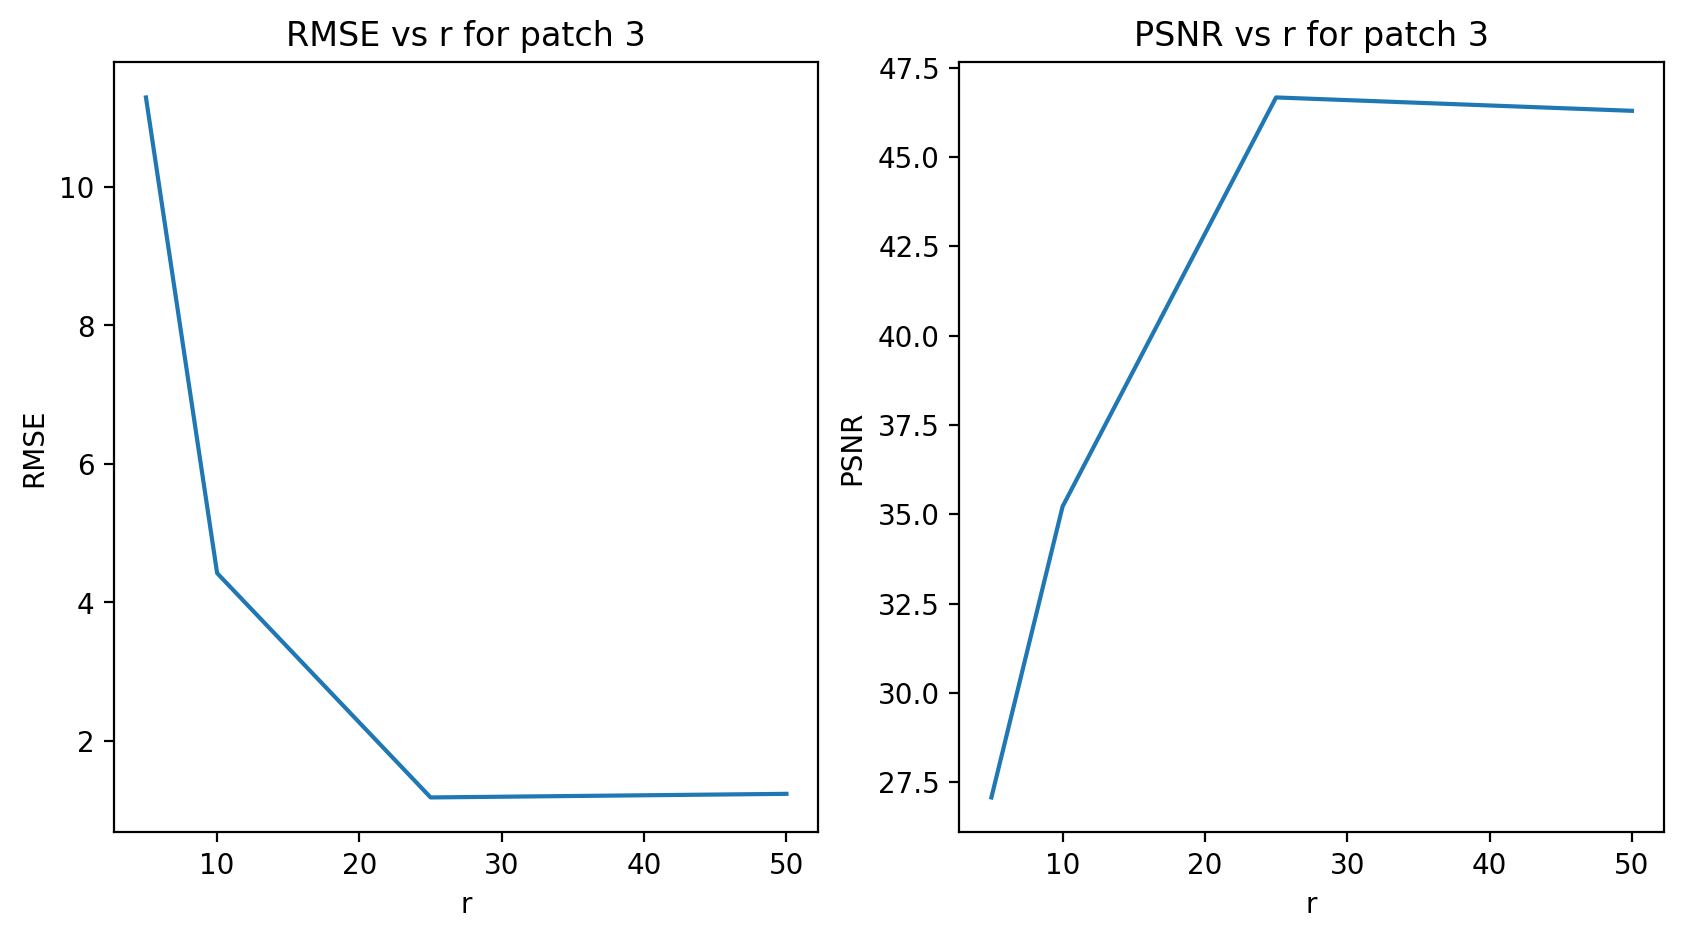

In [36]:
def plot_metrics_vs_r_coloured_img(patch, r_values, patch_number):
	rmse_values = []
	psnr_values = []
	for r in r_values:
		reconstructed, _, loss_R, loss_G, loss_B = factorize_coloured_img(patch, r)
		# reconstructed *= 255
		rmse = calculate_rmse(patch.numpy(), reconstructed.numpy())
		psnr = calculate_psnr(patch.numpy(), reconstructed.numpy())
		rmse_values.append(rmse)
		psnr_values.append(psnr)
		print(f"patch={patch_number} r={r}, RMSE={rmse}, PSNR={psnr}")
 
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].plot(r_values, rmse_values)
	ax[0].set_title("RMSE vs r for patch {}".format(patch_number))
	ax[0].set_xlabel("r")
	ax[0].set_ylabel("RMSE")
	ax[1].plot(r_values, psnr_values)
	ax[1].set_title("PSNR vs r for patch {}".format(patch_number))
	ax[1].set_xlabel("r")
	ax[1].set_ylabel("PSNR")
	plt.show()
 
plot_metrics_vs_r_coloured_img(patch1, [5, 10, 25, 50], 1)
plot_metrics_vs_r_coloured_img(patch2, [5, 10, 25, 50], 2)
plot_metrics_vs_r_coloured_img(patch3, [5, 10, 25, 50], 3)

r=5, Patch 1: RMSE=1.8037144984745506, PSNR=41.76448954960144
r=5, Patch 2: RMSE=12.19426856075701, PSNR=26.407688498962287
r=5, Patch 3: RMSE=15.913045794033907, PSNR=24.0957373571138
r=10, Patch 1: RMSE=1.8597573238563485, PSNR=41.498719920376544
r=10, Patch 2: RMSE=7.607655256873755, PSNR=30.505787124807135
r=10, Patch 3: RMSE=11.94392469252335, PSNR=26.587862479451346
r=25, Patch 1: RMSE=1.8178746252394928, PSNR=41.69656692177254
r=25, Patch 2: RMSE=2.934865527453532, PSNR=38.779039466497466
r=25, Patch 3: RMSE=4.382641059783771, PSNR=35.29608554462398
r=50, Patch 1: RMSE=1.8008161374124616, PSNR=41.778457997804715
r=50, Patch 2: RMSE=1.8624913107915049, PSNR=42.72891850305483
r=50, Patch 3: RMSE=1.5991495490193137, PSNR=44.05302201009144


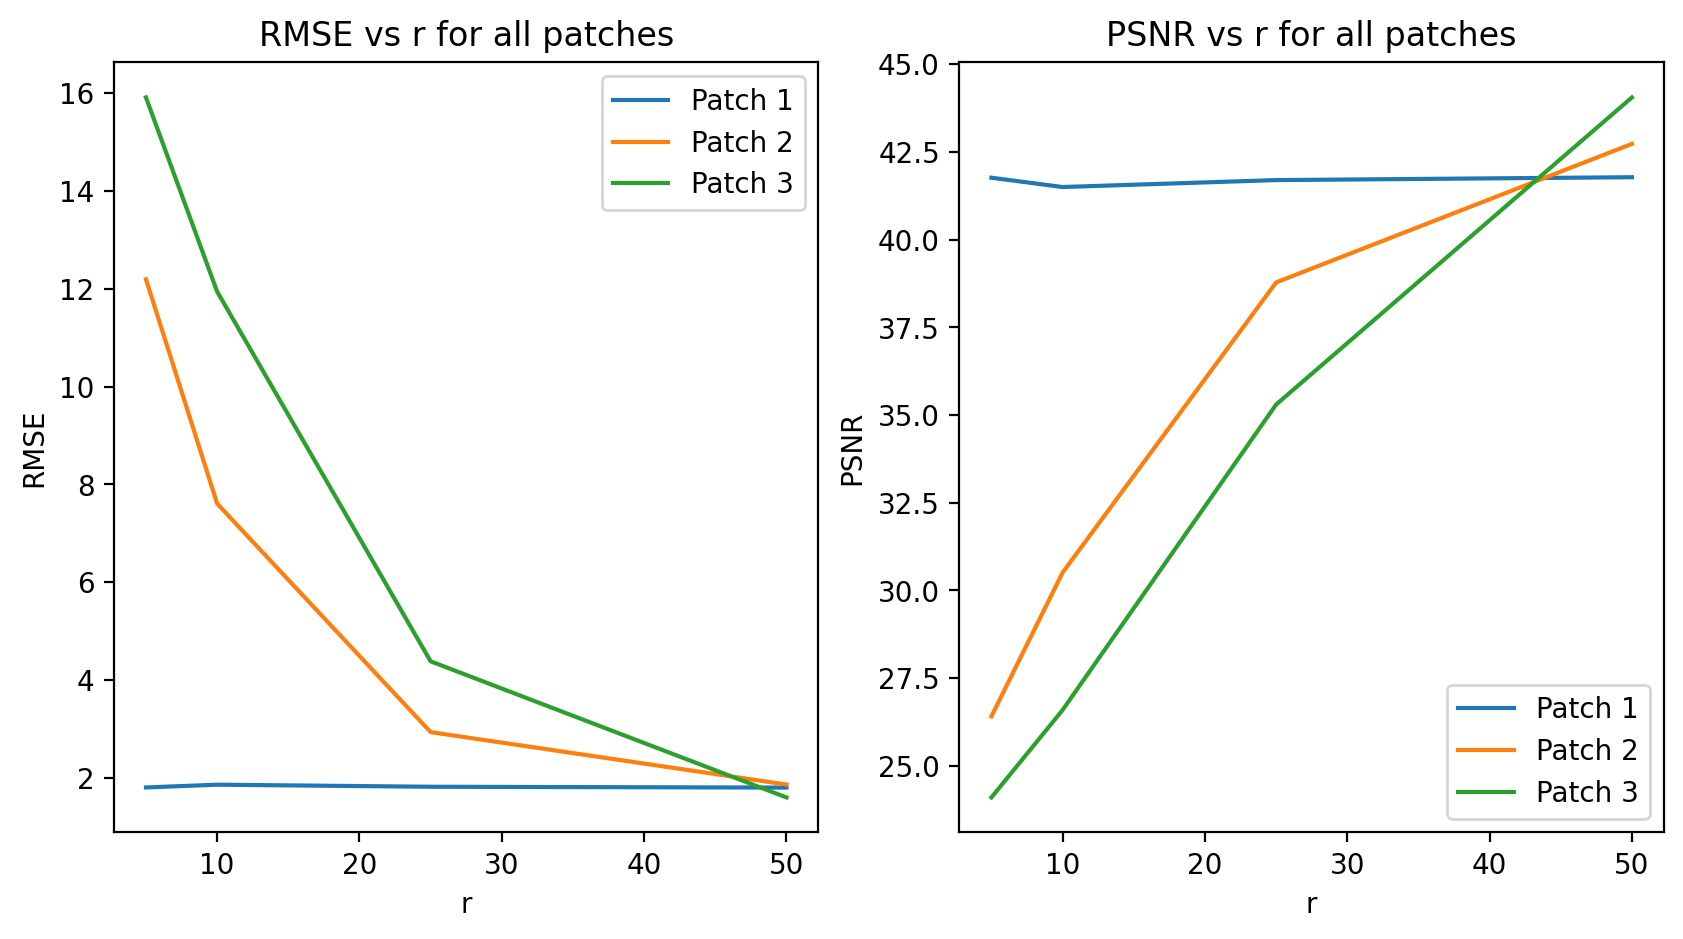

In [56]:
# plot all the metrics for the 3 patches together
def plot_metrics_vs_r_coloured_img_all_patches(patch1, patch2, patch3, r_values):
	rmse_values_patch1 = []
	psnr_values_patch1 = []
	rmse_values_patch2 = []
	psnr_values_patch2 = []
	rmse_values_patch3 = []
	psnr_values_patch3 = []
	for r in r_values:
		reconstructed_patch1, _, loss_R, loss_G, loss_B = factorize_coloured_img(patch1, r)
		reconstructed_patch2, _, loss_R, loss_G, loss_B = factorize_coloured_img(patch2, r)
		reconstructed_patch3, _, loss_R, loss_G, loss_B = factorize_coloured_img(patch3, r)
		rmse_patch1 = calculate_rmse(patch1.numpy(), reconstructed_patch1.numpy())
		psnr_patch1 = calculate_psnr(patch1.numpy(), reconstructed_patch1.numpy())
		rmse_patch2 = calculate_rmse(patch2.numpy(), reconstructed_patch2.numpy())
		psnr_patch2 = calculate_psnr(patch2.numpy(), reconstructed_patch2.numpy())
		rmse_patch3 = calculate_rmse(patch3.numpy(), reconstructed_patch3.numpy())
		psnr_patch3 = calculate_psnr(patch3.numpy(), reconstructed_patch3.numpy())
		rmse_values_patch1.append(rmse_patch1)
		psnr_values_patch1.append(psnr_patch1)
		rmse_values_patch2.append(rmse_patch2)
		psnr_values_patch2.append(psnr_patch2)
		rmse_values_patch3.append(rmse_patch3)
		psnr_values_patch3.append(psnr_patch3)
		print(f"r={r}, Patch 1: RMSE={rmse_patch1}, PSNR={psnr_patch1}")
		print(f"r={r}, Patch 2: RMSE={rmse_patch2}, PSNR={psnr_patch2}")
		print(f"r={r}, Patch 3: RMSE={rmse_patch3}, PSNR={psnr_patch3}")
 
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].plot(r_values, rmse_values_patch1, label="Patch 1")
	ax[0].plot(r_values, rmse_values_patch2, label="Patch 2")
	ax[0].plot(r_values, rmse_values_patch3, label="Patch 3")
	ax[0].set_title("RMSE vs r for all patches")
	ax[0].set_xlabel("r")
	ax[0].set_ylabel("RMSE")
	ax[0].legend()
	ax[1].plot(r_values, psnr_values_patch1, label="Patch 1")
	ax[1].plot(r_values, psnr_values_patch2, label="Patch 2")
	ax[1].plot(r_values, psnr_values_patch3, label="Patch 3")
	ax[1].set_title("PSNR vs r for all patches")
	ax[1].set_xlabel("r")
	ax[1].set_ylabel("PSNR")
	ax[1].legend()
	plt.show()
 
plot_metrics_vs_r_coloured_img_all_patches(patch1, patch2, patch3, [5, 10, 25, 50])